#### importing models and libraries

In [1]:
#Math tools

from scipy import stats
from scipy.stats import skew,norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
import scipy.stats as stats



#Visualizing tools
import seaborn as sns
import matplotlib.pyplot as plt

#preprocessing tools
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

#ml Algorithm 
from sklearn.linear_model import ElasticNetCV , LassoCV, RidgeCV
import sklearn.linear_model as linear_model
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from mlxtend.regressor import StackingCVRegressor

In [2]:
train = pd.read_csv('/home/killerivy/Desktop/project3/data files/train.csv')
test = pd.read_csv('/home/killerivy/Desktop/project3/data files/test.csv')
train_size = train.shape[0]
submission = pd.read_csv("/home/killerivy/Desktop/project3/data files/sample_submission.csv")

import warnings
warnings.filterwarnings(action='ignore')

##### 1. Target variable Distribution

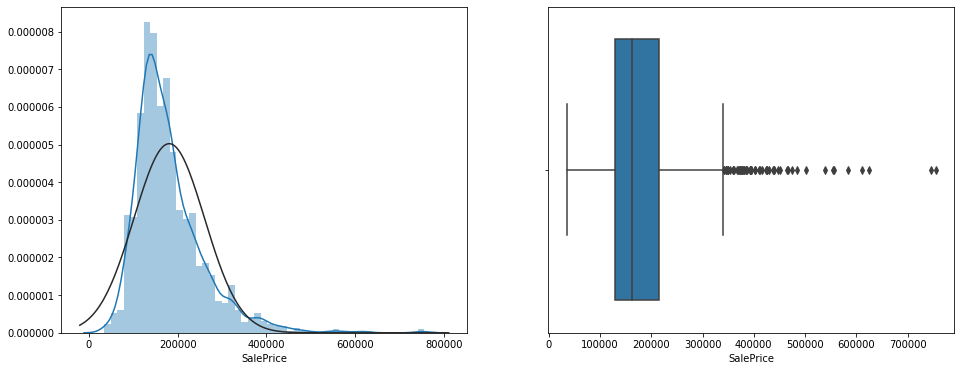

skewness: 1.8828757597682129
Kurtosis: 6.536281860064529
------------------------------------------
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


In [3]:
f,ax = plt.subplots(1,2,figsize=(16,6))
sns.distplot(train['SalePrice'],fit=norm,ax= ax[0])
sns.boxplot(train['SalePrice'])
plt.show()

#skewness and kurtosis
print('skewness: {}'.format(train['SalePrice'].skew()))
print('Kurtosis: {}'.format(train['SalePrice'].kurt()))
print('------------------------------------------')
print(train['SalePrice'].describe())

In [4]:
''' OBSERVATIONS
1. Target variable isnot normally distributed
2. Average sell price is 180921  USD which pulled towards outliers
    values at the upper hand
3. Median 163000 USD which is lower than Mean Value
4. It has couple of outliers at upper hand'''

' OBSERVATIONS\n1. Target variable isnot normally distributed\n2. Average sell price is 180921  USD which pulled towards outliers\n    values at the upper hand\n3. Median 163000 USD which is lower than Mean Value\n4. It has couple of outliers at upper hand'

#### Feature visualization with target variable


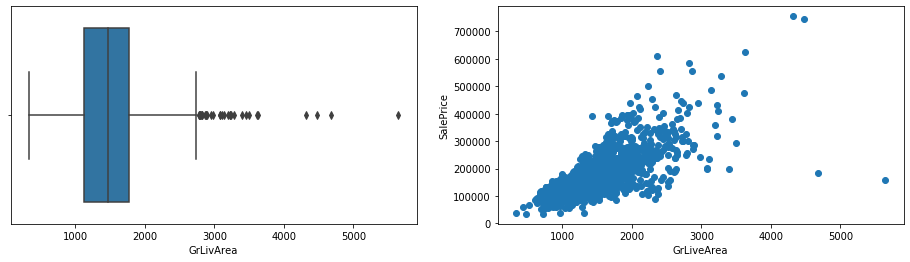

In [5]:
f,ax = plt.subplots(1,2,figsize=(16,4))
sns.boxplot(train['GrLivArea'], ax= ax[0])
plt.scatter(train['GrLivArea'],train['SalePrice'])
plt.xlabel('GrLiveArea')
plt.ylabel('SalePrice')
plt.show()

In [6]:
train.drop(train[train['GrLivArea']> 4500].index,axis=0,inplace=True)

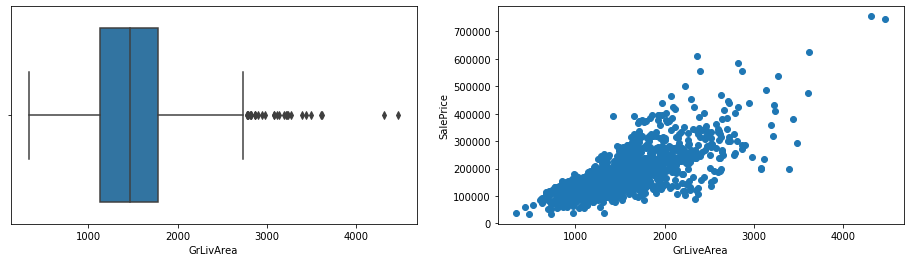

In [7]:
f,ax = plt.subplots(1,2,figsize=(16,4))
sns.boxplot(train['GrLivArea'],ax=ax[0])
plt.scatter(train['GrLivArea'],train['SalePrice'])
plt.xlabel('GrLiveArea')
plt.ylabel('SalePrice')
plt.show()

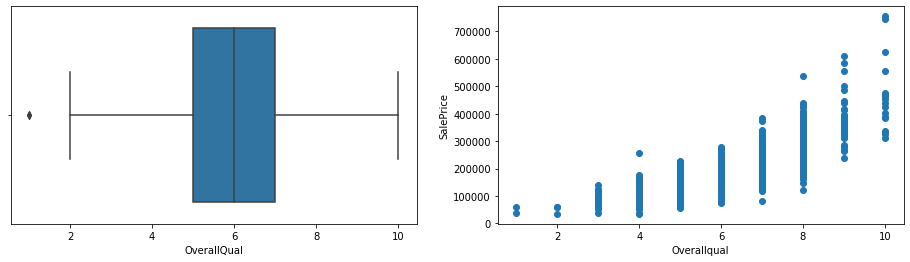

In [8]:
f,ax= plt.subplots(1,2,figsize=(16,4))
sns.boxplot(train['OverallQual'],ax=ax[0])
plt.scatter(train['OverallQual'],train['SalePrice'])
plt.xlabel('Overallqual')
plt.ylabel('SalePrice')
plt.show()

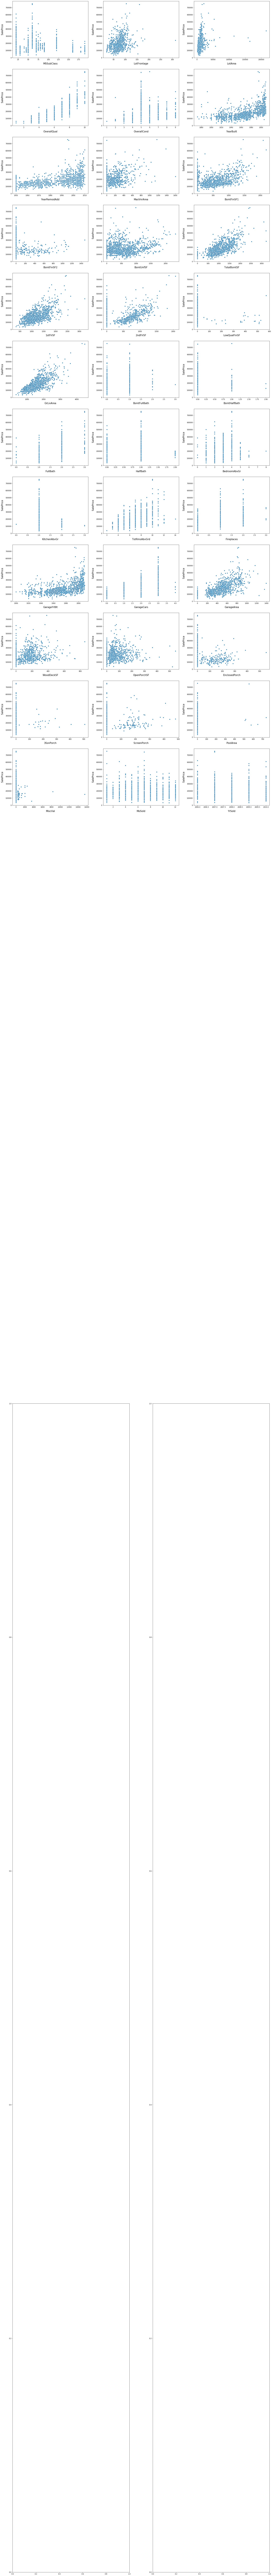

In [9]:
#Finding numeric features

numeric_cols = train.select_dtypes(exclude='object').columns
numeric_cols_length = len(numeric_cols)

fig,axs = plt.subplots(ncols=2,nrows=2,figsize=(12,120))

plt.subplots_adjust(right = 2)
plt.subplots_adjust(top = 2)

#skipped Id and saleprice feature

for i in range(1,numeric_cols_length-1):
    feature = numeric_cols[i]
    plt.subplot(numeric_cols_length,3,i)
    sns.scatterplot(x= feature, y= 'SalePrice', data= train)
    plt.xlabel('{}'.format(feature),size = 15, labelpad= 12.5)
    plt.ylabel('SalePrice', size = 15,labelpad=12.5)
plt.show()

In [10]:
#OBSERVATIONS
'''
1. MSSubClass,Mosold,yrSold- patterns shows it as a category and
    description meant the same
2. OverallQual,OverallCond-Ordered value(like ratings)
3. BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,Fireplaces,BedroomAbvGr,KitchenAvbGr
    -discrete value(no. of bathrooms)'''


'\n1. MSSubClass,Mosold,yrSold- patterns shows it as a category and\n    description meant the same\n2. OverallQual,OverallCond-Ordered value(like ratings)\n3. BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,Fireplaces,BedroomAbvGr,KitchenAvbGr\n    -discrete value(no. of bathrooms)'

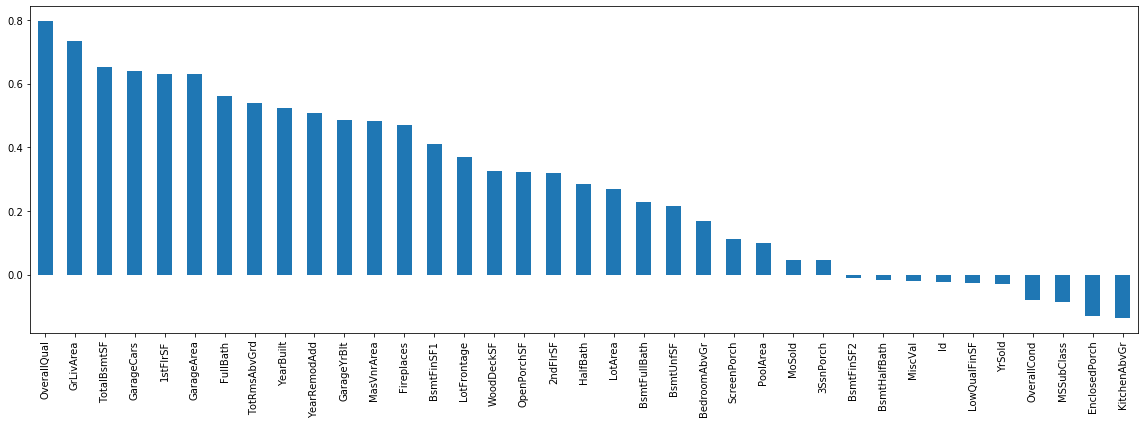

In [11]:
corr = train.select_dtypes(include = 'number').corr()
plt.figure(figsize=(16,6))
corr['SalePrice'].sort_values(ascending=False)[1:].plot(kind='bar')
plt.tight_layout()

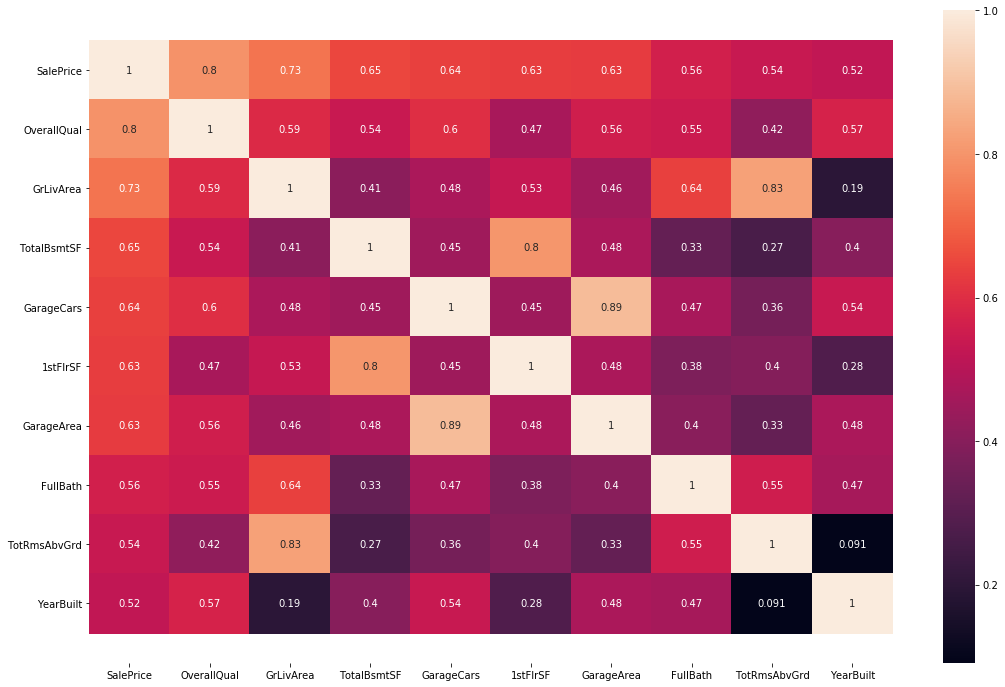

In [12]:
#corelation of top 10 feature with saleprice
corWithSalePrice = train.corr().nlargest(10,'SalePrice')['SalePrice'].index
f,ax = plt.subplots(figsize = (18,12))
ax = sns.heatmap(train[corWithSalePrice].corr(),annot = True)
bottom,top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top -0.5)

plt.show()

In [13]:
 #OBSERVATIONS
'''
1. OverallQual ,GrLivArea, GarageCars, GarageArea and TotalBsmtSF are strongly
        correlated with SalePrice
2. GarageCas and GarageArea are strongly correlated this is because of parking the Garage 
        cars at GarageArea
3. TotRmsAbvGrd and GrLivArea are strongly correleated. When the Ground area increases
        count of rooms also increases
4. TotalBsmtSF and 1stFlrSF are strongly correleated'''

'\n1. OverallQual ,GrLivArea, GarageCars, GarageArea and TotalBsmtSF are strongly\n       correlated with SalePrice\n2. GarageCas and GarageArea are strongly correlated this is because of parking the Garage \n       cars at GarageArea\n3. TotRmsAbvGrd and GrLivArea are strongly correleated. When the Ground area increases\n       count of rooms also increases\n4. TotalBsmtSF and 1stFlrSF are strongly correleated'

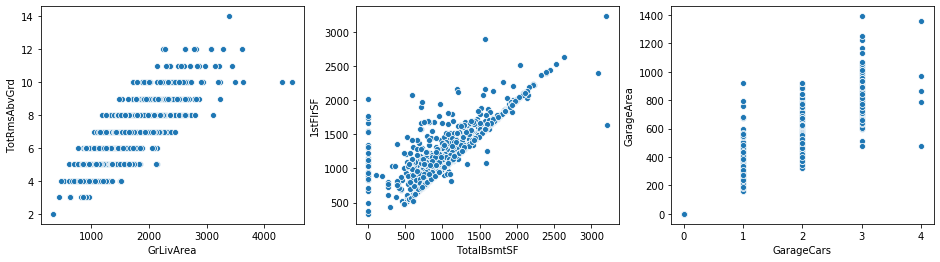

In [14]:
f,ax = plt.subplots(1,3,figsize=(16,4))
sns.scatterplot('GrLivArea','TotRmsAbvGrd', data= train, ax=ax[0])
sns.scatterplot('TotalBsmtSF','1stFlrSF', data= train, ax=ax[1])
sns.scatterplot('GarageCars','GarageArea', data= train, ax=ax[2])
plt.show()

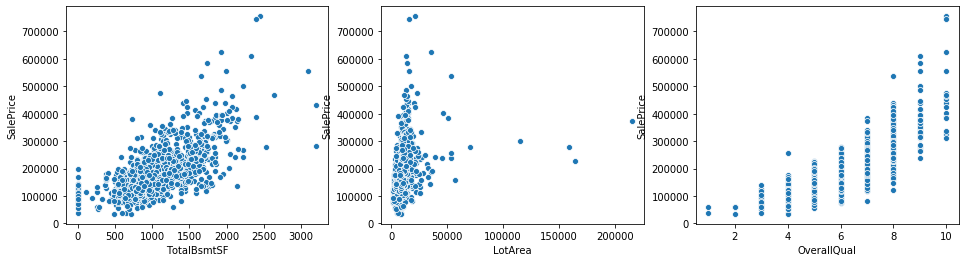

In [15]:
f,ax = plt.subplots(1,3,figsize=(16,4))
sns.scatterplot(x='TotalBsmtSF', y= 'SalePrice', data= train,ax=ax[0])
sns.scatterplot(x='LotArea', y= 'SalePrice', data= train,ax=ax[1])
sns.scatterplot(x='OverallQual', y= 'SalePrice', data= train,ax=ax[2])
plt.show()

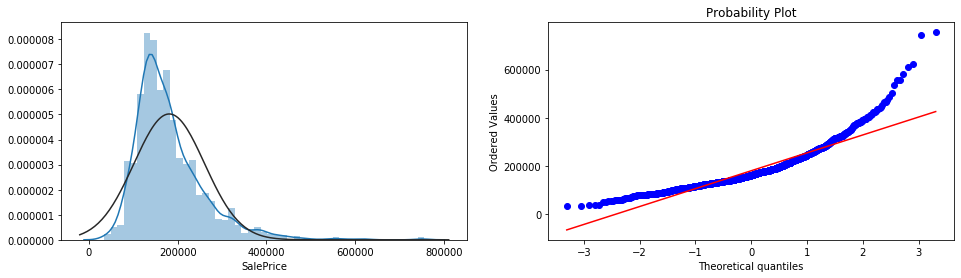

Skewness:1.8812964895244009
Kurtosis:6.523066888485879


In [16]:
#After Removing the two outlier,
#you can see that skewnes s is reduced.
#Still SalePrice is not normally distributed
f,ax = plt.subplots(1,2,figsize=(16,4))
sns.distplot(train['SalePrice'], ax=ax[0],fit = norm)
stats.probplot(train['SalePrice'],plot=plt)
plt.show()

#skewness and kurtosis
print('Skewness:{}'.format(train['SalePrice'].skew()))
print('Kurtosis:{}'.format(train['SalePrice'].kurt()))

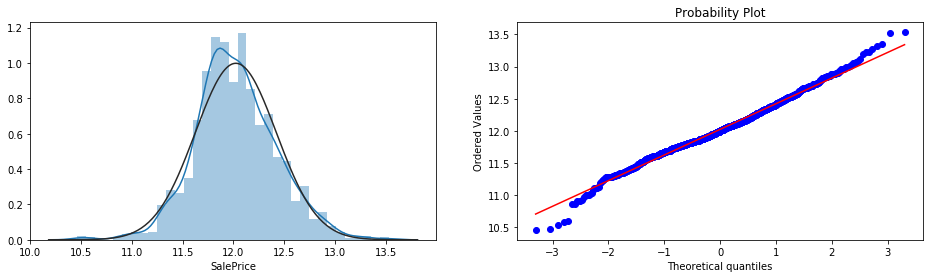

Skewness: 0.12157976050304879
Kurtosis: 0.8047507917418972


In [17]:
#log Transformation
y= np.log1p(train['SalePrice'])

f,ax= plt.subplots(1,2,figsize = (16,4))
sns.distplot(y,fit=norm,ax=ax[0])
stats.probplot(y,plot=plt)
plt.show()

#skewness nad kurtosis
print('Skewness: {}'.format(y.skew()))
print('Kurtosis: {}'.format(y.kurt()))

In [18]:
def remove_overfit_features(df,weight):
    overfit=[]
    for i in df.columns:
        counts = df[i].value_counts()
        zeros = counts.iloc[0]
        if zeros / len(df)* 100 > weight:
            overfit.append(i)
    overfit = list(overfit)
    return overfit


overfitted_features = remove_overfit_features(train,99)
train.drop(overfitted_features,inplace = True,axis =1)
test.drop(overfitted_features,inplace = True,axis =1)

In [19]:
train_labels = y
train_features = train.drop(['SalePrice'],axis = 1)
test_features = test

#combine train and test features in order to apply the feature transformation
#pipeline to th entire dataset

all_features = pd.concat([train_features,test_features]).reset_index(drop = True)


In [20]:
all_features.drop('Id',inplace=True ,axis=1)
all_features.shape

(2917, 75)

#### 3.Imputing missing values

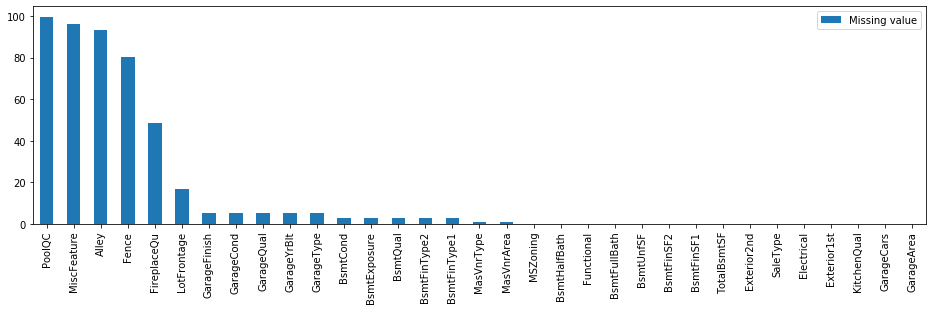

In [21]:
# Visualize missing data
missing_value = all_features.isnull().sum().sort_values(ascending = False) / len(all_features) * 100
missing_value = missing_value[missing_value != 0]
missing_value = pd.DataFrame({'Missing value' : missing_value, 'Type' :missing_value.index.map(lambda x:all_features[x].dtype)})
missing_value.plot(kind= 'bar',figsize=(16,4))
plt.show()

In [22]:
print("Total No. of missing value {} before Imputation".format(sum(all_features.isnull().sum())))
def fill_missing_values():
 
    fillSaleType = all_features[all_features['SaleCondition'] == 'Normal']['SaleType'].mode()[0]
    all_features['SaleType'].fillna(fillSaleType,inplace=True)

    fillElectrical = all_features[all_features['Neighborhood']=='Timber']['Electrical'].mode()[0]
    all_features['Electrical'].fillna(fillElectrical,inplace=True)

    exterior1_neighbor = all_features[all_features['Exterior1st'].isnull()]['Neighborhood'].values[0]
    fillExterior1 = all_features[all_features['Neighborhood'] == exterior1_neighbor]['Exterior1st'].mode()[0]
    all_features['Exterior1st'].fillna(fillExterior1,inplace=True)

    exterior2_neighbor = all_features[all_features['Exterior2nd'].isnull()]['Neighborhood'].values[0]
    fillExterior2 = all_features[all_features['Neighborhood'] == exterior1_neighbor]['Exterior1st'].mode()[0]
    all_features['Exterior2nd'].fillna(fillExterior2,inplace=True)

    bsmtNeigh = all_features[all_features['BsmtFinSF1'].isnull()]['Neighborhood'].values[0]
    fillBsmtFinSf1 = all_features[all_features['Neighborhood'] == bsmtNeigh]['BsmtFinSF1'].mode()[0]
    all_features['BsmtFinSF1'].fillna(fillBsmtFinSf1,inplace=True)

    kitchen_grade = all_features[all_features['KitchenQual'].isnull()]['KitchenAbvGr'].values[0]
    fillKitchenQual = all_features[all_features['KitchenAbvGr'] == kitchen_grade]['KitchenQual'].mode()[0]
    all_features['KitchenQual'].fillna(fillKitchenQual,inplace=True)
        
    all_features['MSZoning'] = all_features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
       
    all_features['LotFrontage'] = all_features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
    
    for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond','BsmtQual', 'BsmtCond', 'BsmtExposure',
                'BsmtFinType1', 'BsmtFinType2','PoolQC']:
        all_features[col] = all_features[col].fillna('None')
    
    categorical_cols =  all_features.select_dtypes(include='object').columns
    all_features[categorical_cols] = all_features[categorical_cols].fillna('None')
    
    numeric_cols = all_features.select_dtypes(include='number').columns
    all_features[numeric_cols] = all_features[numeric_cols].fillna(0)
    
    all_features['Shed'] = np.where(all_features['MiscFeature']=='Shed', 1, 0)
    
    #GarageYrBlt -  missing values there for the building which has no Garage, imputing 0 makes huge difference with other buildings,
    #imputing mean doesn't make sense since there is no Garage. So we'll drop it
    all_features.drop(['GarageYrBlt','MiscFeature'],inplace=True,axis=1)
    
    all_features['QualitySF'] = all_features['GrLivArea'] * all_features['OverallQual']

fill_missing_values()

print("Total No. of missing value {} after Imputation".format(sum(all_features.isnull().sum())))

Total No. of missing value 13956 before Imputation
Total No. of missing value 0 after Imputation


In [23]:
all_features = all_features.drop(['PoolQC',],axis = 1)

#### Fix Skewed features

In [24]:
#converting some numeric features to string
all_features['MSSubClass'] = all_features['MSSubClass'].apply(str)
all_features['YrSold'] = all_features['YrSold'].astype(str)
all_features['MoSold'] = all_features['MoSold'].astype(str)

#Filter th skewed features
numeric = all_features.select_dtypes(include='number').columns
skew_features = all_features[numeric].apply(lambda x:skew(x)).sort_values(ascending = False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print('There are {} numerical features wih Skew > 0.5:'.format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew':high_skew})
skew_features.head(10)

There are 26 numerical features wih Skew > 0.5:


MiscVal          21.939672
LotArea          13.109495
LowQualFinSF     12.084539
3SsnPorch        11.372080
Shed              5.266776
KitchenAbvGr      4.300550
BsmtFinSF2        4.144503
EnclosedPorch     4.002344
ScreenPorch       3.945101
BsmtHalfBath      3.929996
dtype: float64

In [25]:
# Normalize skewed features using boxcox
for i in skew_index:
    all_features[i] = boxcox1p(all_features[i],boxcox_normmax(all_features[i]+1))

#### Feature Creation

In [26]:
all_features['YearsSinceRemodel'] = all_features['YrSold'].astype(int) - all_features['YearRemodAdd'].astype(int)
all_features['Total_Home_Quality'] = all_features['OverallQual'] + all_features['OverallCond']

all_features['TotalSF'] = all_features['TotalBsmtSF'] + all_features['1stFlrSF'] + all_features['2ndFlrSF']
all_features['YrBltAndRemod'] = all_features['YearBuilt'] + all_features['YearRemodAdd']
all_features['BsmtFinType1_Unf'] = 1*(all_features['BsmtFinType1'] == 'Unf')
all_features['Total_sqr_footage'] = (all_features['BsmtFinSF1'] + all_features['BsmtFinSF2'] + all_features['1stFlrSF'] + all_features['2ndFlrSF'])
all_features['Total_Bathrooms'] = (all_features['FullBath'] + (0.5 * all_features['HalfBath']) + all_features['BsmtFullBath'] + (0.5 * all_features['BsmtHalfBath']))
all_features['Total_porch_sf'] = (all_features['OpenPorchSF']+ all_features['3SsnPorch']+all_features['EnclosedPorch'] + all_features['ScreenPorch']+ all_features['WoodDeckSF'])
all_features['TotalBsmtSF'] = all_features['TotalBsmtSF'].apply(lambda x:np.exp(6) if x<= 0.0 else x)
all_features['2ndFlrSF'] = all_features['2ndFlrSF'].apply(lambda x: np.exp(6.5) if x<= 0.0 else x)
all_features['GarageArea'] = all_features['GarageArea'].apply(lambda x: np.exp(6) if x<= 0.0 else x)
all_features['BsmtFinSF1'] = all_features['BsmtFinSF1'].apply(lambda x: np.exp(6.5) if x<= 0.0 else x)

In [27]:
def booleanFeatures(columns):
    for col in columns:
        all_features[col+'_bool'] = all_features[col].apply(lambda x: 1 if x> 0 else 0)
booleanFeatures(['GarageArea', 'TotalBsmtSF','2ndFlrSF','Fireplaces','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch'])

In [28]:
def logs(columns):
    for col in columns:
        all_features[col+'_log'] = np.log(1.01+all_features[col])
log_features = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','2ndFlrSF','LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageCars','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','MiscVal','YearRemodAdd','TotalSF']
logs(log_features)

In [29]:
def squares(columns):
    for col in columns:
        all_features[col+'_sq'] = all_features[col] * all_features[col]
squared_features = ['GarageCars_log','YearRemodAdd', 'LotFrontage_log', 'TotalBsmtSF_log', '2ndFlrSF_log', 'GrLivArea_log' ]

squares(squared_features)

#### Feature transformation

In [30]:
# There is anatural order in their values for few categories, so convertingthem to number gives more meaning

quality_map = {'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4, 'Ex':5}

quality_cols = ['BsmtQual', 'BsmtCond','ExterQual', 'ExterCond','FireplaceQu','GarageQual', 'GarageCond','KitchenQual','HeatingQC']
for col in quality_cols:
    all_features[col] = all_features[col].replace(quality_map)
    
all_features['BsmtExposure'] = all_features['BsmtExposure'].replace({"No":0, "Mn":1, "Av":2, "Gd":3})

all_features['PavedDrive'] = all_features['PavedDrive'].replace({"N" : 0, "P": 1, "Y": 2})

bsmt_ratings = {"None" : 0,"Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6}

bsmt_col = ['BsmtFinType1','BsmtFinType2']
for col in bsmt_col:
    all_features[col] = all_features[col].replace(bsmt_ratings)

all_features["OverallScore"] = all_features["OverallQual"] * all_features["OverallCond"]

all_features["GarageScore"] = all_features["GarageQual"] * all_features["GarageCond"]

all_features["ExterScore"] = all_features["ExterQual"] * all_features["ExterCond"]

In [31]:
all_features = pd.get_dummies(all_features).reset_index(drop = True)

In [32]:
X = all_features.iloc[:len(train_labels), :]
X_test = all_features.iloc[len(train_labels):, :]
outliers = [30,88,462,631,1322]
X= X.drop(X.index[outliers])
train_labels = train_labels.drop(y.index[outliers])

In [33]:
overfitted_features = remove_overfit_features(X,99)

X = X.drop(overfitted_features, axis = 1)
X_test = X_test.drop(overfitted_features, axis = 1)

#### Training a model

In [34]:
kf = KFold(n_splits= 12, random_state= 42, shuffle= True)

#Define error metrics
def rmsle(y,y_pred):
    return np.sqrt(mean_squared_error(y,y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model,X,train_labels,scoring = "neg_mean_squared_error", cv=kf))
    return (rmse)


In [35]:
#Ridge Regressor
ridge_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
ridge = make_pipeline(RobustScaler(),RidgeCV(alphas = ridge_alphas, cv=kf))

#Support Vector Regressor
svr = make_pipeline(RobustScaler(),SVR(C=20,epsilon =0.008, gamma = 0.0003))


#Light Gradient Boosing Regressor

lightgbm = LGBMRegressor(objective='regression',
                        num_leaves=6,
                        learning_rate=0.01,
                        n_estimators=7000,
                        max_bin=200,
                        bagging_fraction= 0.8,
                        bagging_freq=4,
                        bagging_seed=8,
                        feature_fraction=0.2,
                        feature_fraction_seed=8,
                        min_sum_hessian_in_leaf = 11,
                        verbose=-1,
                        random_state=42)


#Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=6000,
                               learning_rate=0.01,
                               max_depth=4,
                               max_features='sqrt',
                               min_samples_leaf=15,
                               min_samples_split=10,
                               loss='huber',
                               random_state=42)

#XGBoost Regressor
xgboost = XGBRegressor(learning_rate=0.01,
                        n_estimators=3460,
                        max_depth=3,
                        min_child_weight=0,
                        gamma=0,
                        subsample=0.7,
                        colsample_bytree=0.7,
                        objective='reg:linear',
                        nthread=-1,
                        scale_pos_weight=1,
                        seed=27,
                        reg_alpha=0.00006,
                        random_state=42)

#StackingCVRegressor
stackReg = StackingCVRegressor(regressors=(xgboost,svr,ridge,gbr),meta_regressor=xgboost,use_features_in_secondary=True,random_state=42)

In [36]:
model_score={}

score = cv_rmse(lightgbm)
lgb_model_full_data = lightgbm.fit(X,train_labels)
print("lightgbm : {:.4f}".format(score.mean()))
model_score['lgb'] = score.mean()

lightgbm : 0.1081


In [37]:
score = cv_rmse(xgboost)
xgb_model_full_data = xgboost.fit(X,train_labels)
print("xgboost: {:.4f}".format(score.mean()))
model_score['xgb'] = score.mean()

[15:52:50] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1593723605503/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:53:07] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1593723605503/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:53:07] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1593723605503/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:53:25] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1593723605503/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:53:25] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1593723605503/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:53:43] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost

In [38]:
score= cv_rmse(svr)
svr_model_full_data = svr.fit(X,train_labels)
print("SVR:{:.4f} ({:.4f})".format(score.mean(),score.std()))
model_score['svr'] = score.mean()

SVR:0.1024 (0.0141)


In [39]:
score = cv_rmse(ridge)
ridge_model_full_data = ridge.fit(X,train_labels)
print("ridge:{:.4f}".format(score.mean()))
model_score['ridge'] = score.mean()

ridge:0.1034


In [40]:
score = cv_rmse(gbr)
gbr_model_full_data = gbr.fit(X,train_labels)
print("gbr:{:.4f}".format(score.mean()))
model_score['gbr'] = score.mean()

gbr:0.1061


In [41]:
stackReg_reg_model = stackReg.fit(np.array(X),np.array(train_labels))

[16:01:07] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1593723605503/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[16:01:23] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1593723605503/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[16:01:23] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1593723605503/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[16:01:39] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1593723605503/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[16:01:39] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1593723605503/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[16:01:54] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost

In [42]:
def blended_predictions(X,weight):
    return ((weight[0] * ridge_model_full_data.predict(X))+ \
            (weight[1] * svr_model_full_data.predict(X))+ \
            (weight[2] * gbr_model_full_data.predict(X))+ \
            (weight[3] * xgb_model_full_data.predict(X))+ \
            (weight[4] * lgb_model_full_data.predict(X))+ \
            (weight[5] * stackReg_reg_model.predict(np.array(X)))
           )

In [43]:
# Blended model predictions
blended_score = rmsle(train_labels,blended_predictions(X,[0.15,0.2,0.1,0.15,0.1,0.3]))
print("blended score:{:.4f}".format(blended_score))
model_score['blended_model'] = blended_score

blended score:0.0540


In [44]:
pd.Series(model_score).sort_values(ascending=True)

blended_model    0.053959
svr              0.102380
ridge            0.103429
gbr              0.106073
xgb              0.106254
lgb              0.108079
dtype: float64

#### Predictions

In [51]:
#read submission csv
submission = pd.read_csv('/home/killerivy/Desktop/project3/data files/sample_submission.csv')

#predictions
submission.iloc[:,1] = np.floor(np.expm1(blended_predictions(X_test,[0.15,0.2,0.1,0.15,0.1,0.3])))

#write to csv
submission.to_csv("submission.csv",index=False)
submission.to_excel("submission.xlsx",index=False)